In [442]:
import glob
import os
import pandas as pd
import numpy as np

def read_http_logs(client_dir, label='end-to-end'):
    file = os.path.join(client_dir, 'rate_client_%s' % label)
    df = pd.read_csv(file, sep='\t')
    df.TIME -= df.TIME.min()
    df.TIME *= 1e-9
    df.VALUE *= 1e-3
    return df

def read_pinning_experiment(base_dir, suffix):
    def read_client_dir(exp):
        return read_http_logs(os.path.join(base_dir, exp + suffix, 'client'))
    
    return OrderedDict([
        ('TCP Non-isolated', read_client_dir('tcp_unpinned')),
        ('HTTP Non-isolated', read_client_dir('http_unpinned')),
        ('No isolation', read_client_dir('no_pinned')),
        ('all isolated', read_client_dir('all_pinned'))
    ])

In [484]:
exps1 = read_pinning_experiment('http_no_isolation', '_2')
evil = read_pinning_experiment('http_no_isolation', '_aaaaaaaaab')
merge_rerun= read_pinning_experiment('http_no_isolation', '_merge_rerun_3')

In [493]:
comparison = {
    'Before': exps1['all isolated'],
    'After': read_http_logs('rerun/all_pinned_1/client')
}

In [494]:
def plot_cdf(df, flip=False, **kwargs):
    value = df.VALUE
    x, y = sorted(value), np.arange(len(value)) / len(value)
    if flip:
        y = 1-y
    plt.plot(x, y, '-',  linewidth=1, **kwargs)

def calc_cdf(df, round_on):
    value = df.VALUE
    x, y = sorted(value), np.arange(len(value)) / len(value)
    
    df = pd.DataFrame(np.array([x, y]).T, columns=['latency', 'probability'])
    
    if round_on:
        df[round_on] = df[round_on].round(5)
        df = df.groupby(round_on).mean()
    return df.reset_index()
    
def calc_pdf(df):
    hist, edges = np.histogram(value, bins=np.arange(0, round(value.max()), .0005), density=True)
    df = pd.DataFrame({'probability': hist.T, 'latency': edges.T[1:]})
    
    df['latency'] = df['latency'].round(1)
    df = df.groupby('latency').mean()
    return df.reset_index()

In [495]:
def compare_timeseries(dfs, **kwargs):
    for label, df in dfs.items():
        plt.plot(df.TIME, df.VALUE, '.', label=label, **plkwargs)

        
def compare_cdfs(dfs, startup_time = 0, end_time = None, group_label = "", flip=False ):
    for label, df in dfs.items():
        df = df[df.TIME > startup_time]
        if end_time is not None:
            df = df[df.TIME < end_time]
        plot_cdf(df, flip=flip, label=label + group_label)

<IPython.core.display.Javascript object>


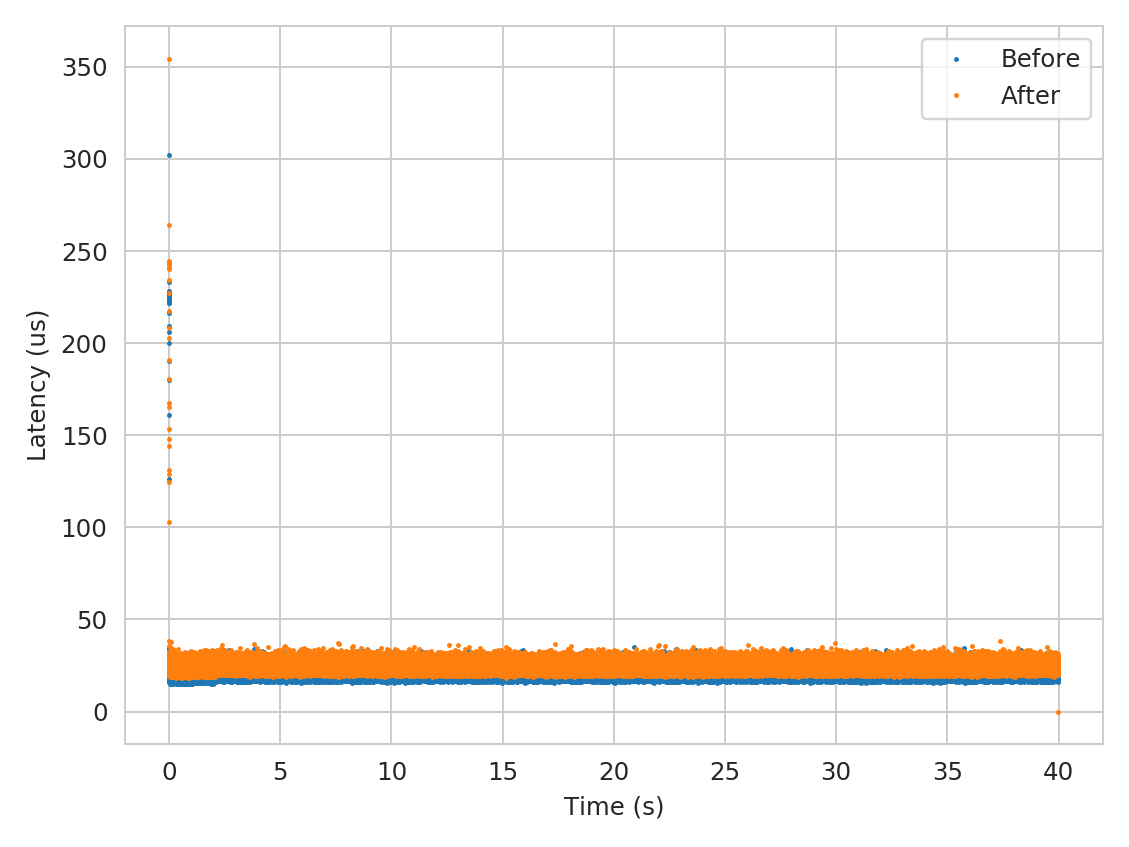

/home/iped/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [496]:
%matplotlib notebook
import matplotlib.pyplot as plt

plkwargs = dict(markersize=2, alpha=1)

plt.figure()

compare_timeseries(comparison)
# compare_timeseries(merge_rerun)


plt.xlabel("Time (s)")
plt.ylabel("Latency (us)")
plt.legend()
# plt.yscale('log')

ax = plt.gca()

ax.set_yticks([], minor=True)
_, hi = ax.get_ylim()
# ax.set_yticks(range(50, int(hi), 50))
# ax.set_yticklabels(['25', '50', '75', '100', '150'])

plt.tight_layout()

<IPython.core.display.Javascript object>


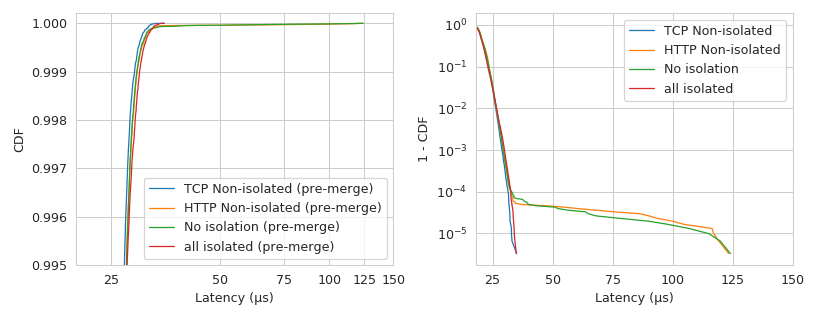

/home/iped/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [518]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(9, 3.5))
ax = plt.subplot(122)
compare_cdfs(exps1, 2, flip=True)# group_label = " (pre-merge)")

# compare_cdfs(exps1, 2,flip=True, group_label=" (pre-merge)")
# compare_cdfs(merge_rerun, 2, flip=True, group_label=" (post-merge)")



plt.yscale('log')
# plt.ylim([.99, 1.0005])
# plt.xscale('log')
plt.legend()
plt.xlabel("Latency (µs)")
plt.ylabel("1 - CDF")

ax.set_xticks([], minor=True)
ax.set_xticks([25, 50, 75, 100, 125, 150])
ax.set_xticklabels(['25', '50', '75', '100', 125, '150'])
ax.set_xlim([18, 150])
ax = plt.subplot(121)
# compare_cdfs(comparison, 2)# group_label = " (pre-merge)")
compare_cdfs(exps1, 2, group_label = " (pre-merge)")

# plt.yscale('log')
plt.ylim([.995, 1.0002])
plt.xlim([20, 150])


plt.xscale('log')
plt.legend()
plt.xlabel("Latency (µs)")
plt.ylabel("CDF")

ax.set_xticks([], minor=True)
ax.set_xticks([25, 50, 75, 100, 125, 150])
ax.set_xticklabels(['25', '50', '75', '100', 125, '150'])
plt.tight_layout()

plt.grid(True, 'major', 'x')

<IPython.core.display.Javascript object>


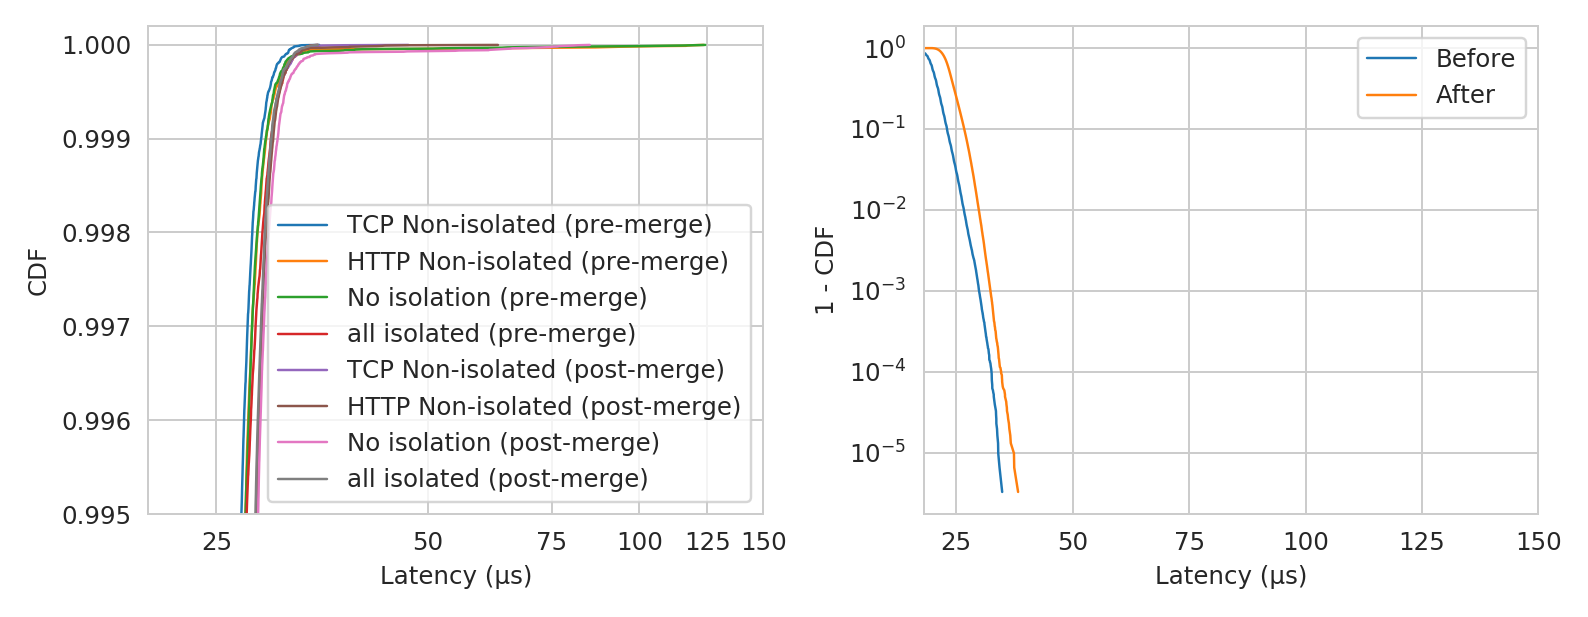

/home/iped/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [497]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(9, 3.5))
ax = plt.subplot(122)
compare_cdfs(comparison, 2, flip=True)# group_label = " (pre-merge)")

# compare_cdfs(exps1, 2,flip=True, group_label=" (pre-merge)")
# compare_cdfs(merge_rerun, 2, flip=True, group_label=" (post-merge)")



plt.yscale('log')
# plt.ylim([.99, 1.0005])
# plt.xscale('log')
plt.legend()
plt.xlabel("Latency (µs)")
plt.ylabel("1 - CDF")

ax.set_xticks([], minor=True)
ax.set_xticks([25, 50, 75, 100, 125, 150])
ax.set_xticklabels(['25', '50', '75', '100', 125, '150'])
ax.set_xlim([18, 150])
ax = plt.subplot(121)
# compare_cdfs(comparison, 2)# group_label = " (pre-merge)")
compare_cdfs(exps1, 2, group_label = " (pre-merge)")
compare_cdfs(merge_rerun, 2, group_label = " (post-merge)")


# plt.yscale('log')
plt.ylim([.995, 1.0002])
plt.xlim([20, 150])


plt.xscale('log')
plt.legend()
plt.xlabel("Latency (µs)")
plt.ylabel("CDF")

ax.set_xticks([], minor=True)
ax.set_xticks([25, 50, 75, 100, 125, 150])
ax.set_xticklabels(['25', '50', '75', '100', 125, '150'])
plt.tight_layout()

plt.grid(True, 'major', 'x')

In [366]:
from collections import OrderedDict
rates = [100, 200, 500, 1000, 2000, 5000]
rate_test = OrderedDict()

for rate in rates:
    rate_test[rate] = read_http_logs('http_rate_test_3/rate_%d/client' % rate)



<IPython.core.display.Javascript object>


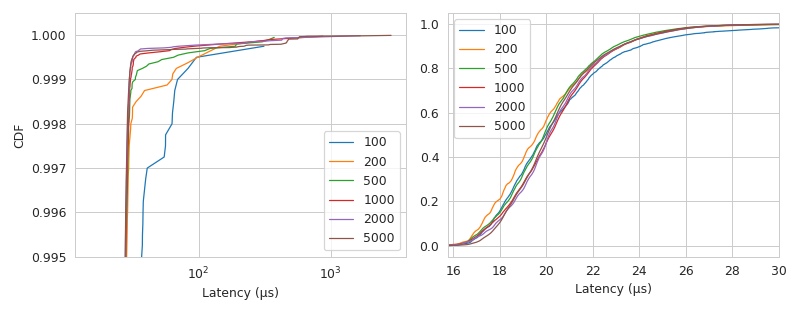

/home/iped/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [139]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(9, 3.5))
plt.subplot(121)

for rate, df in rate_test.items():
    plot_cdf(df, label=rate)
    
plt.legend()
plt.ylim([.995, 1.0005])
# plt.xlim([15, 600])
plt.legend()
plt.xlabel("Latency (µs)")
plt.ylabel("CDF")
plt.xscale('log')

plt.subplot(122)

for rate, df in rate_test.items():
    plot_cdf(df, label=rate)
    
plt.xlim([rate_test[100].VALUE.min(), 30])
# plt.xscale('log')
plt.legend()
plt.xlabel("Latency (µs)")

plt.tight_layout()